In [69]:
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [11]:
import os

In [28]:
item_data = [] 
coll_data = []
for root,folders,files in os.walk('data'):
    for f in files:
        if 'item' in f:
            with open(root+'/'+f) as item_base:
                df = pd.read_csv(item_base)
                item_data.append(df)
        if 'collection' in f:
            with open(root+'/'+f) as coll_base:
                df = pd.read_csv(coll_base)
                coll_data.append(df)

In [35]:
item_data[0]

,Unnamed: 0,identifier,title,creator,date,depositor,box,folder,type_of_resource,genre
0,0,31735061656561,"""Democracy Should Begin At Home""",NaN,1894-2008,University of Pittsburgh,2.0,5.0,text,archival document
1,1,31735061659946,"""Delegate, Special Convention Communist Party,...",NaN,1894-2008,University of Pittsburgh,3.0,18.0,text,archival document
2,2,31735060482829,"Tenement Children Protest, New York City,",NaN,1934-02-26; 1894-2008,University of Pittsburgh,13.0,62.0,text,archival document
3,3,31735065151247,Mine-Mill union; Mine Mill union; Sindicato; U...,NaN,NaN,"International Union of Mine, Mill, and Smelter...",NaN,NaN,text; text,periodical; Periodicals.; Periodicals; Periodi...
4,4,31735061544221,"""What Are You Doing About Your Undeclared War?...",NaN,1963-06-03; 1894-2008,University of Pittsburgh,11.0,145.0,text,archival document
...,...,...,...,...,...,...,...,...,...,...
1630,1630,31735061544437,"""Washington Action"" Flyer",NaN,1894-2008,University of Pittsburgh,11.0,158.0,text,archival document
1631,1631,31735061538421,"Women and Equality, By Margaret Cowl,",NaN,1935-02; 1894-2008,University of Pittsburgh,6.0,5.0,text,archival document
1632,1632,31735061543967,"""Problems of Revolutionary Socialism"", By Haim...",NaN,1894-2008,University of Pittsburgh,10.0,102.0,text,archival document
1633,1633,31735061544650,"""Constitution of the Socialist Party"",",NaN,1983; 1894-2008,University of Pittsburgh,11.0,1.0,text,archival document


In [36]:
all_titles = []
for df in item_data:
    item_titles = " ".join(list(df['title']))
    all_titles.append(item_titles)
all_titles[0][:100]

'"Democracy Should Begin At Home" "Delegate, Special Convention Communist Party, U.S.A., July 4-7, 19'

In [50]:
#make labels by getting collection names (same order)
coll_titles = []
for df in coll_data:
    try:
        coll_titles.append(df['collection_title'].loc[0])
    except:
        coll_titles.append("Fred Wright Cartoons")
coll_titles

['American Left Ephemera Collection',
 'Fred Wright Cartoons',
 'Hervey Allen Papers',
 'Communist Collection of A.E. Forbes']

In [65]:
#tokenize, vectorize, tfidf 
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=u'(?ui)\\b\\w*[a-z][a-z][a-z]\\w*', max_df=1.0)
X = vectorizer.fit_transform(all_titles)
print(len(vectorizer.get_feature_names()))

5088


In [66]:
full_data = X.todense()

In [70]:
B = nx.Graph()
# coll_titles for nodes
B.add_nodes_from(coll_titles)

In [115]:
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
indices = list(range(len(coll_titles)))
combos = combinations(indices, 2)

# cos sim for edge data 
for j,k in combos:
    weight = cosine_similarity(full_data[j], full_data[k])[0][0]
    B.add_edge(coll_titles[j], coll_titles[k])
    B[coll_titles[j]][coll_titles[k]]['weight'] = weight 
edge_labels ={}
for u,v in B.edges():
    weight = B.get_edge_data(u,v)['weight']
    edge_labels[(u,v)] = weight
    

In [237]:
%matplotlib inline
import matplotlib.pyplot as plt

pos=nx.fruchterman_reingold_layout(B)
pos

{'American Left Ephemera Collection': array([ 0.22744312, -0.31641323]),
 'Fred Wright Cartoons': array([0.64386975, 0.08210331]),
 'Hervey Allen Papers': array([-1.        , -0.23733297]),
 'Communist Collection of A.E. Forbes': array([0.12868713, 0.47164289])}

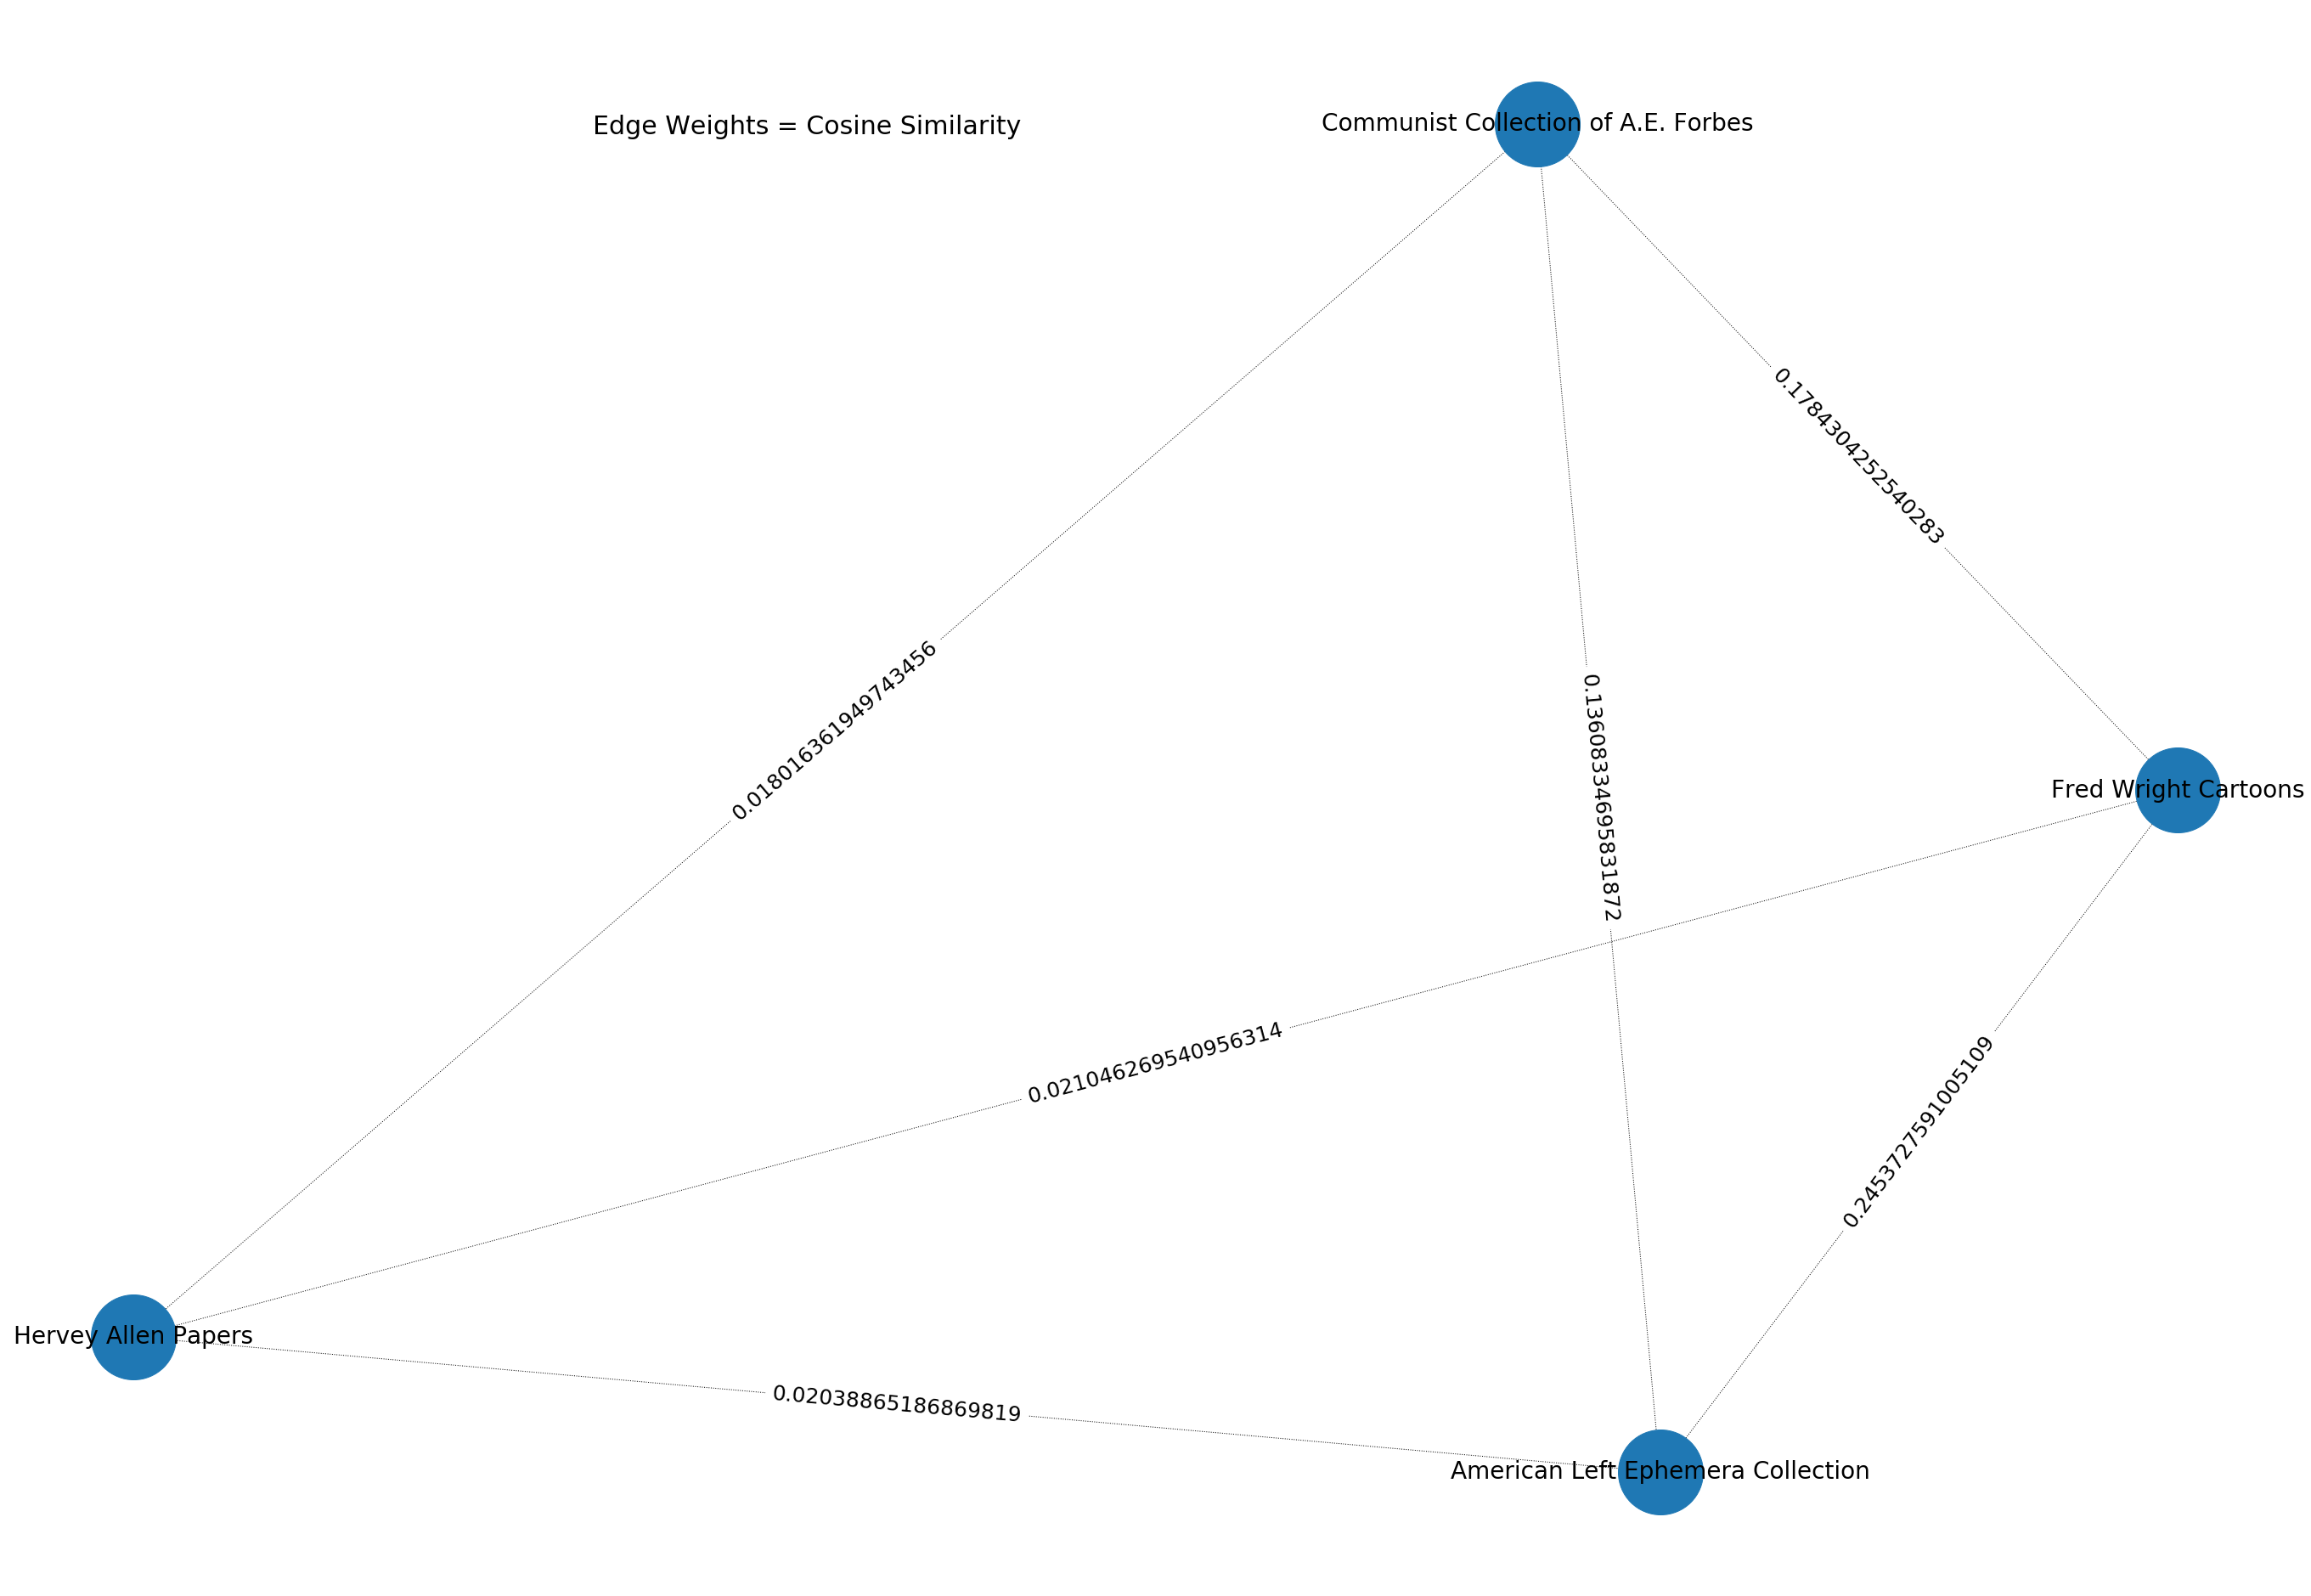

In [248]:
fig, ax = plt.subplots(figsize=(8,7))

fig.subplots_adjust(-2.15, -1.85, 2.55, 1.85)
nx.draw(B, with_labels=True, node_size=10000, pos=pos, style='dotted', font_size='28')
nx.draw_networkx_edge_labels(B, pos=pos, edge_labels=edge_labels, font_size='25') #edge_labels must have keys for edges, and then values

fig.text(-0.95, 1.55, 'Edge Weights = Cosine Similarity', ha='left', fontsize='30')

plt.savefig('test-graph.png', bbox_inches = "tight")
plt.show()


In [240]:
import numpy as np 
#pos['Fred Wright Cartoons'] = np.array([ 0.44, -0.4])
pos

{'American Left Ephemera Collection': array([ 0.22744312, -0.31641323]),
 'Fred Wright Cartoons': array([0.64386975, 0.08210331]),
 'Hervey Allen Papers': array([-1.        , -0.23733297]),
 'Communist Collection of A.E. Forbes': array([0.12868713, 0.47164289])}